# GAN

Simple MNIST GAN with adversarial training <br>

## Setup

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')
root_path = 'gdrive/My Drive/Python/GAN'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import os
import glob
import time

import numpy as np
import pandas as pd
import tensorflow as tf
from IPython import display
from matplotlib import pyplot as plt
from tqdm import tqdm as progress_bar

## Data

Use MNIST data set stored on Google Drive. 

In [ ]:
mnist_df = pd.read_csv(os.path.join(root_path, "train.csv"))
train_images = mnist_df.loc[:, "pixel0": "pixel783"].values
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1)
labels = mnist_df["label"].values

Convert images to [-1, 1] range. 

In [ ]:
def normalize_image(image):
    return (image.astype("float32") - 127.5) / 127.5

train_images = np.apply_along_axis(normalize_image, 1, train_images)

Create TensorFlow data set from loaded images. 

In [ ]:
BUFFER_SIZE = 60000
BATCH_SIZE = 250

# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## Model

Create Convolutional GAN in a single Python class. <br>

In [ ]:
class MNISTGAN:
    def __init__(self, latent_dim=100):
        self.latent_dim = latent_dim
        self.generator = tf.keras.Sequential()
        # processing input distribution
        self.generator.add(tf.keras.layers.Dense(7*7*256, use_bias=False, input_shape=(latent_dim,)))
        self.generator.add(tf.keras.layers.BatchNormalization())
        self.generator.add(tf.keras.layers.LeakyReLU())
        self.generator.add(tf.keras.layers.Reshape((7, 7, 256)))
        # Conv2DTranspose upsampling with batch norm
        self.generator.add(tf.keras.layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding="same", use_bias=False))
        self.generator.add(tf.keras.layers.BatchNormalization())
        self.generator.add(tf.keras.layers.LeakyReLU())
        # Conv2DTranspose upsampling with batch norm
        self.generator.add(tf.keras.layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding="same", use_bias=False))
        self.generator.add(tf.keras.layers.BatchNormalization())
        self.generator.add(tf.keras.layers.LeakyReLU())
        # final Conv2DTranspose upsampling
        self.generator.add(tf.keras.layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding="same", use_bias=False, activation="tanh"))

        self.discriminator = tf.keras.Sequential()
        # Conv layer with dropout
        self.discriminator.add(tf.keras.layers.Conv2D(64, (5, 5), strides=(2, 2), padding="same", input_shape=[28, 28, 1]))
        self.discriminator.add(tf.keras.layers.LeakyReLU())
        self.discriminator.add(tf.keras.layers.Dropout(0.3))
        # Conv layer with dropout
        self.discriminator.add(tf.keras.layers.Conv2D(128, (5, 5), strides=(2, 2), padding="same"))
        self.discriminator.add(tf.keras.layers.LeakyReLU())
        self.discriminator.add(tf.keras.layers.Dropout(0.3))
        # output layer returning probability
        self.discriminator.add(tf.keras.layers.Flatten())
        self.discriminator.add(tf.keras.layers.Dense(1))

        self.loss_function = tf.keras.losses.BinaryCrossentropy(from_logits=True)

        self.generator_optimizer = tf.keras.optimizers.Adam(1e-4)
        self.discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

    def discriminator_loss(self, real_output, fake_output):
        real_loss = self.loss_function(tf.ones_like(real_output), real_output)
        fake_loss = self.loss_function(tf.zeros_like(fake_output), fake_output)
        total_loss = real_loss + fake_loss
        
        return total_loss

    def generator_loss(self, fake_output):
        return self.loss_function(tf.ones_like(fake_output), fake_output)

    def generate(self, n_images=1):
        input_noise = tf.random.normal([n_images, self.latent_dim])
        return self.generator(input_noise, training=False)

    def predict(self, images):
        return self.discriminator.predict(images)

    def fit(self, dataset, n_epochs, batch_size=256, silent=False):
        for epoch in progress_bar(range(n_epochs), disable=silent):
            for image_batch in dataset:
                self.train_step(image_batch, batch_size)

    @tf.function
    def train_step(self, images, batch_size):
        noise = tf.random.normal([batch_size, self.latent_dim])

        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_images = self.generator(noise, training=True)

            real_output = self.discriminator(images, training=True)
            fake_output = self.discriminator(generated_images, training=True)

            gen_loss = self.generator_loss(fake_output)
            disc_loss = self.discriminator_loss(real_output, fake_output)

        gradients_of_generator = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)

        self.generator_optimizer.apply_gradients(zip(gradients_of_generator, self.generator.trainable_variables))
        self.discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, self.discriminator.trainable_variables))


In [ ]:
gan = MNISTGAN()

In [ ]:
gan.fit(train_dataset, 50)

100%|██████████| 50/50 [05:58<00:00,  7.18s/it]


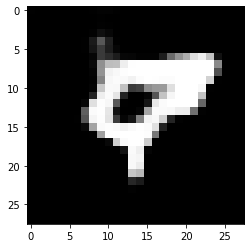

In [ ]:
generated_image = gan.generate()

_ = plt.imshow(generated_image[0, :, :, 0], cmap="gray")

In [ ]:
gan.predict(generated_image)

array([[-0.8117558]], dtype=float32)

In [ ]:
gan.predict([np.random.randn(28*28).reshape(1, 28, 28, 1)])

array([[-13.752408]], dtype=float32)